In [32]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sb
sb.set()
h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


In [2]:
seed = 1337
layer = "all"
np.random.seed(seed)
n_hl = 12
hidden_dim = 768

In [3]:
def get_inputs(filename, layer):
    """Read data from pkl file and prepare for training."""
    file = open(filename + ".pkl", "rb")
    data = pickle.load(file)
    author_ids, data_x, data_y = list(zip(*data))
    file.close()

    # alphaW is responsible for which BERT layer embedding we will be using
    if layer == "all":
        alphaW = np.full([n_hl], 1 / n_hl)

    else:
        alphaW = np.zeros([n_hl])
        alphaW[int(layer) - 1] = 1

    # just changing the way data is stored (tuples of minibatches) and
    # getting the output for the required layer of BERT using alphaW
    inputs = []
    targets = []
    n_batches = len(data_y)
    print("n_batches:", n_batches)
    for ii in range(n_batches):
        extra_inputs = np.einsum("k,kij->ij", alphaW, data_x[ii])
        extra_targets = data_y[ii]
        if len(extra_inputs) == len(extra_targets):
            inputs.extend(extra_inputs)
            targets.extend(data_y[ii])
        else:
            print("skipped a batch")
        
    inputs = np.array(inputs)
    full_targets = np.array(targets)

    return inputs, full_targets

In [36]:
filename = "embeddings/reddit-albert-base-mean-130k_cleaned"
filename = "embeddings/reddit-albert-base-mean-12k_cleaned"
# filename = "embeddings/reddit-albert-base-mean-5k_cleaned"
data_x, data_y = get_inputs(filename, layer)

#maybe do this
data_x = StandardScaler().fit_transform(data_x)
x_train, x_test, real_y_train, real_y_test = train_test_split(data_x, data_y, test_size = 0.2)

n_batches: 387


In [37]:
labels = ["Extraversion (E) vs Introversion (I)", "Intuition (N) vs Sensing (S)", "Feeling (F) vs Thinking (T)", "Judging (J) vs Perceiving (P)" ]
idx = 0
y_train = real_y_train[:, idx]
y_test = real_y_test[:, idx]

In [39]:
x_min, x_max = np.min(data_x) - 0.5, np.max(data_x) + 0.5
y_min, y_max = np.min(data_y) - 0.5, np.max(data_y) + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Trying out: Nearest Neighbors

Classification Accuracy:	 0.5194174757281553
F1 score: 0.47985989492119085
Precision: 0.4691780821917808
Recall: 0.4910394265232975
Accuracy: 0.5194174757281553
Took 95 seconds




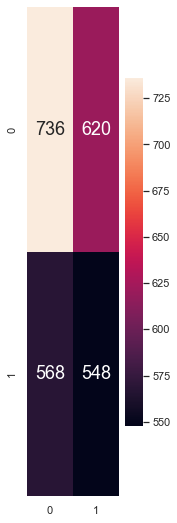

In [40]:
figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}\n")
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})
i += 1



Trying out: RBF SVM
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5736245954692557
F1 score: 0.1127946127946128
Precision: 0.9305555555555556
Recall: 0.06003584229390681
Accuracy: 0.5736245954692557
Took 264 seconds




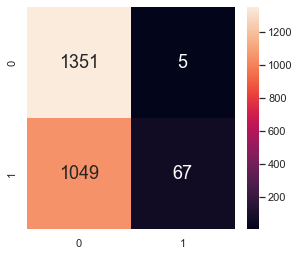

In [63]:
figure = plt.figure(figsize=(27, 9))
i = 3

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

<AxesSubplot:>

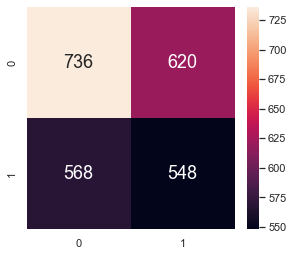